#Predicting the Default of Customers of a Credit Card Operator

The original dataset can be found at the [link](https://https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

#Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from xgboost import plot_importance




#Dataset
About Dataset:



This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



In [2]:
!pip install xlrd==1.2.0 #Requires installation of this version on google Colab
df = pd.read_excel('default of credit card clients.xls', header=1)
df.drop(['ID'], axis =1, inplace=True )


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [5]:
df.describe(include = 'all').transpose()

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


In [6]:
print(df['default payment next month'].value_counts())
print(df['default payment next month'].value_counts(normalize = True))

0    23364
1     6636
Name: default payment next month, dtype: int64
0    0.7788
1    0.2212
Name: default payment next month, dtype: float64


In [7]:
df.corr()[['default payment next month']].sort_values(by='default payment next month', ascending=False)

,default payment next month
default payment next month,1.000000
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
EDUCATION,0.028006
AGE,0.013890
BILL_AMT6,-0.005372


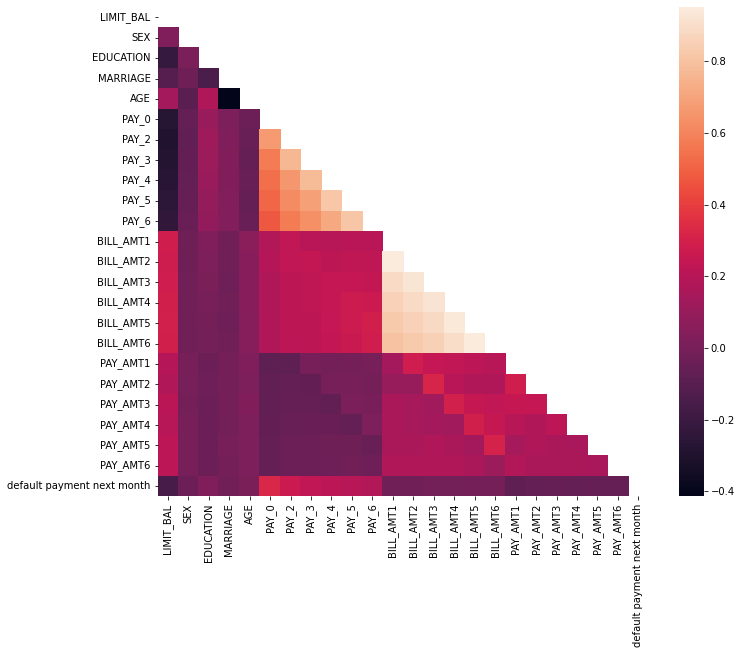

In [8]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(df.corr(), mask=mask)

#Data pre-processing and Balance the data


In [9]:
X = df.drop(['default payment next month'], axis=1)
y = df['default payment next month'].copy()

In [10]:
#Random Undersampling 
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Train and Test the Model

In [11]:
def classification_whit_report(model, X, y, k, serial, verbose=False):
   
  fpr = []
  tpr = []
  roc_auc = []
  original_class = []
  predicted_class = []
  predicted_proba = []
  
  skf = StratifiedKFold(k)
  
  i = 0
  # Train and test the model for each `k` fold in all the data.
  for train_index, test_index in skf.split(X,y):
    if verbose:
      print(f'-- Running with {i}th fold.')
    model.fit(X.iloc[train_index], y[train_index])
    y_pred_probability = model.predict_proba(X.iloc[test_index])

    # Predict to generate classification report
    y_pred = model.predict(X.iloc[test_index])
    predicted_class.extend(y_pred)
    original_class.extend(y[test_index])
		
		# Compute micro-average ROC curve and ROC area.
    temp_fpr, temp_tpr, _ = roc_curve(y[test_index], y_pred_probability[:,1])
    fpr.append(temp_fpr)
    tpr.append(temp_tpr)
    roc_auc.append(auc(temp_fpr,temp_tpr))
    i +=1

	#Plot the graphic
  plot_roc_curve(model, fpr, tpr, roc_auc, k)

  #Insert Results in file
  print ("== Confusion Matrix ==")
  print(confusion_matrix(original_class, predicted_class))
  print( "\n")
  print ("== Classification Report ==")
  print(classification_report(original_class, predicted_class))
  print( "\n")
  print ("== ROC AUC Values ==")
  print(roc_auc)



def plot_roc_curve(model, fpr, tpr, roc_auc, k):
  # Config the plot.
  plt.figure(figsize=(10, 10))
  plt.grid()
  plt.plot([0, 1], [0, 1], ls='--')
  plt.ylim([-0.01, 1.01])
  plt.xlim([-0.01, 1.01])
  plt.xlabel('False Positive Rate', size=16)
  plt.ylabel('True Positives Rate', size=16)

  linspace = np.linspace(0, 1, 100)

  # Calc the mean roc.
  int_tpr = [np.interp(linspace, fpr[i], tpr[i]) for i in range(k)]
  mean_tpr = np.mean(int_tpr, axis=0)

  # Plot all roc curves for each fold and the average roc curve.
  for i in range(k):
    plt.plot(fpr[i], tpr[i], label=f'fold {i}, Area: {roc_auc[i]:.4f}')
  plt.plot(linspace, mean_tpr, label=f'Average Curve, Area: {auc(linspace, mean_tpr):.4f} (+/- {np.std(roc_auc)*2:.2f})')

  # Plot the graphic.
  plt.legend(prop={'size': 16})
  plt.show()

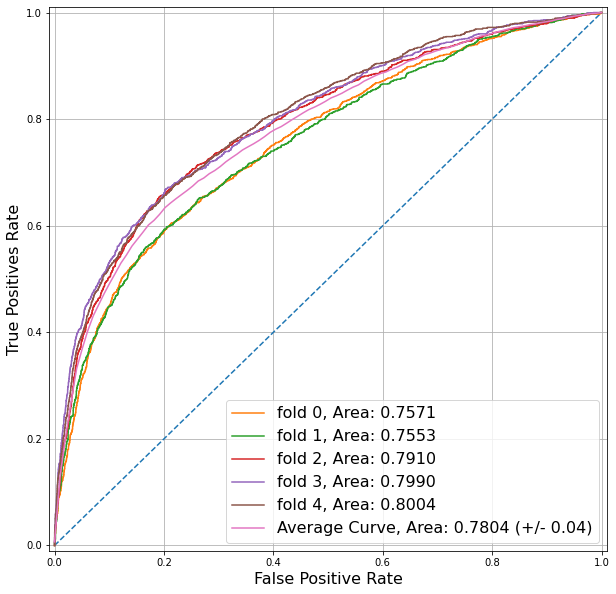

== Confusion Matrix ==
[[22227  1137]
 [ 4227  2409]]


== Classification Report ==
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.68      0.36      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.66      0.68     30000
weighted avg       0.80      0.82      0.80     30000



== ROC AUC Values ==
[0.757091239530038, 0.755319040856007, 0.7910254535063378, 0.7989855300802071, 0.8003995600114884]


In [12]:
model = xgb.XGBClassifier()
classification_whit_report(model, X, y, 5, '01', verbose=False)


<Figure size 1152x720 with 0 Axes>

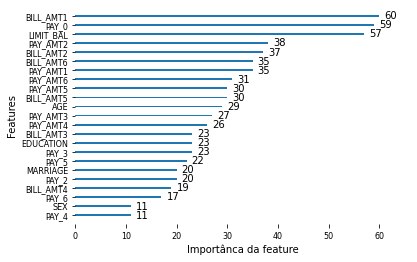

In [13]:
fig = plt.figure(figsize=(16,10))
plot_importance(model, title=None, grid=False)

plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.autolayout"] = True
plt.yticks(fontsize=8);
plt.xticks(fontsize=8);

# Axis texts
plt.xlabel('Importânca da feature', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.box(on=False)
plt.show(block=False) # Pĺot show

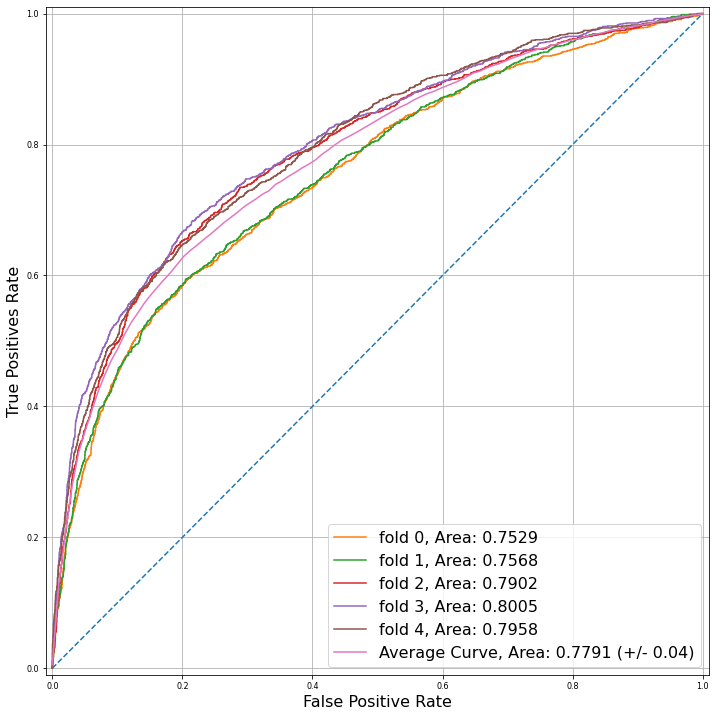

== Confusion Matrix ==
[[22151  1213]
 [ 4217  2419]]


== Classification Report ==
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.67      0.36      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.75      0.66      0.68     30000
weighted avg       0.80      0.82      0.80     30000



== ROC AUC Values ==
[0.7529171963968888, 0.756821523249774, 0.7901915652957368, 0.8005247803161744, 0.7957768101671469]


In [14]:
model = lgb.LGBMClassifier()
classification_whit_report(model, X, y, 5, '02', verbose=False)
#Plot feature importance


<Figure size 1152x720 with 0 Axes>

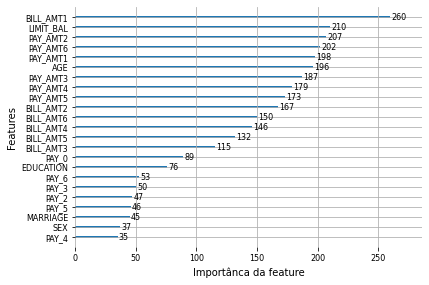

In [15]:
fig = plt.figure(figsize=(16,10))
lgb.plot_importance(model, title=None)
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.autolayout"] = True
plt.yticks(fontsize=8);
plt.xticks(fontsize=8);

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True

# Axis texts
plt.xlabel('Importânca da feature', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.box(on=False)
plt.show(block=False) # Pĺot show